In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from tqdm.notebook import tqdm
from scipy.signal import welch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qick.rfboard import RFQickSocV2
soc = RFQickSocV2('qick_111_rfbrd_v2.bit')
# Load bitstream with custom overlay
# soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")

soccfg = soc
print(soccfg)

resetting clocks: 204.8

QICK configuration:

	Board: ZCU111

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, switch ch 0, maxlen 65536
		DAC tile 0, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	1:	axis_signal_gen_v6 - tProc output 2, switch ch 1, maxlen 65536
		DAC tile 0, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	2:	axis_signal_gen_v6 - tProc output 3, switch ch 2, maxlen 65536
		DAC tile 0, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	3:	axis_signal_gen_v6 - tProc output 4, switch ch 3, maxlen 65536
		DAC tile 1, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	4:	axis_signal_gen_v6 - tProc output 5, switch ch 4, maxlen 65536
		DAC tile 1, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	5:	axis_signal_gen_v6 - tProc output 6, switch ch 5, maxlen 65536
		DAC tile 1, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	6:	axis_signal_gen_v6 - tProc out

### SET UP CONFIGURATION

In [3]:
# darkfreq800 = [6.18807, 5.8285, 6.075045, 5.95940] # Best for 800 gain
# qubitresPulse = [4.800, 4.6571, 4.4928, 4.6518]

hw_cfg={"res_ch":5,
        "qubit_ch":2,
        "ro_ch":1,
        "f_res":5828.5,
        "f_ge": 4657.1
       }

rfb_cfg={"f_lo_ro":122.88*56,
         "f_lo_qubit":122.88*28,
        "att_res":(0,14.5),
        "att_qubit":(0,16),
         "att_ro":30
       }
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=0, verbose=True) # ADCs
soc.rfb_set_lo(rfb_cfg['f_lo_qubit'], ch=1, verbose=True) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
soc.rfb_set_gen_rf(gen_ch=hw_cfg['qubit_ch'], att1=rfb_cfg['att_qubit'][0], att2=rfb_cfg['att_qubit'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])

meas_cfg={"pulse_gain":800,
    "if_res": abs(soc.rfb_get_lo(gen_ch=hw_cfg['res_ch']) - hw_cfg['f_res']), # MHz, start value
    "if_ge": abs(soc.rfb_get_lo(gen_ch=hw_cfg['qubit_ch']) - hw_cfg['f_ge']), # MHz, start value
          "nqz":1
       }

print("qubit IF=%f, readout IF=%f"%(meas_cfg['if_ge'], meas_cfg['if_res']))

  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 13762.56 |   2 |       2 |  112 |  False |    1 |    1 |     1 |  122.88 |  6881.28 |    0.00 | 2.2400e+02

Choosing solution 0 with minimal metric 224.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 13762.56 |   4 |       2 |  112 |  False |    1 |    1 |     1 |  122.88 |  3440.64 |    0.00 | 4.4800e+02

Choosing solution 0 with minimal metric 448.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|----

In [4]:
#res_range = [5800, 6200]
#qubit_range = [4400, 4900]

# high LO for readout, low LO for qubit, 2:1 relation
# f_lo_ro = 122.88*56 # 6881
# f_lo_qubit = 122.88*28 # 3441

# common LO: low LO for readout, high LO for qubit
# want to keep readout sidebands outside qubit range:
# put LO closer to readout
# f_lo_ro = 122.88*46 # 5652
# f_lo_qubit = 122.88*46
# put LO closer to qubit - probably preferred, since external filter will kill RO lower sideband
# f_lo_ro = 122.88*41 # 5038
# f_lo_qubit = 122.88*41

# various considerations, not all mutually compatible:

# LO performance is best if you use an integer multiple of the reference clock (122.88 MHz)
# LO freqs <7.5 GHz are generated using a divider, so you will see some of the original VCO freq (some multiple of the LO)
# the mixers allow a fair bit of LO leakage, and there also seems to be some crosstalk between LOs
# so you get a cleaner spectrum if you use a single LO
# second best: use LOs that are simple multiples of each other

# the low-pass filter we use on both ADC and DAC IF (LFCN-1800D) is ~2.1 GHz
# the ADC Nyquist freq is ~1.5 GHz, so IFs above ~900 MHz see up to 3 dB more (2x) noise power
# this assumes the noise spectrum is broadband and white
# and it may not be the limiting factor in the measurement - have to see

# on the DAC side, the max IF is just set by the low-pass
# anything up to 1.8 GHz (rated band of the filter) should be OK

# we're using double-sideband mixers, so you will always see both LO+IF and LO-IF, only one of which is desired
# for your qubit drive, this means dumping a lot of power at some random freq - might be harmless?
# for readout, the spur is also going to get mixed back down to your IF, so this basically means you have a second readout path that is always off-resonance
# the RF outputs are low-passed at ~7 GHz (LFCW-6800), so it's nice if you can set your LO high enough that only LO-IF is passed
# or of course you can add an external filter
# VBFZ-6260 only starts really killing stuff below ~4.8, so it is not perfect protection for the qubits
# 



### SET UP SWEEP

  0%|          | 0/20100 [00:00<?, ?it/s]

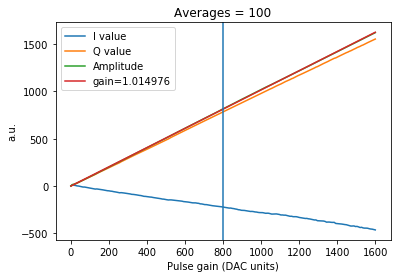

In [5]:
class GainSweepProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=cfg['nqz'], ro_ch=cfg["ro_ch"])

        self.r_rp=self.ch_page(self.cfg["res_ch"])     # get register page for res_ch
        self.r_gain=self.sreg(cfg["res_ch"], "gain")   #Get gain register for res_ch
        
        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], freq=cfg["if_res"],
                             length=soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"]),
                             gen_ch=cfg["res_ch"])

        self.set_pulse_registers(ch=cfg["res_ch"], style="const",
                                 length=soccfg.us2cycles(cfg['length'], gen_ch=cfg['res_ch']),
                                 freq=soccfg.freq2reg(cfg['if_res'],gen_ch=cfg['res_ch'],ro_ch=cfg["ro_ch"]),
                                 gain=cfg["start"],
                                 phase=0)
        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=soccfg.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
    def update(self):
        self.mathi(self.r_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the pulse

sweepconfig={
    'nqz': 1,
    'adc_trig_offset': 0.35,
    'length': 10,
    'readout_padding': 0.2,
    'relax_delay': 1,
    'reps': 100,
    "expts": 201,
    "start":0, # [DAC units]
    "step":int(meas_cfg['pulse_gain']/100) # [DAC units]
       }
config={**hw_cfg,**rfb_cfg,**meas_cfg, **sweepconfig} #combine configs

prog =GainSweepProgram(soccfg, config)
expt_pts, avgi, avgq = prog.acquire(soc, load_pulses=True, progress=True)

# Plot results.
sig = avgi[0][0] + 1j*avgq[0][0]
avgamp0 = np.abs(sig)
plt.figure(1)
plt.plot(expt_pts, avgi[0][0], label="I value")
plt.plot(expt_pts, avgq[0][0], label="Q value")
plt.plot(expt_pts, avgamp0, label="Amplitude")
gain = avgamp0[config['expts']//3]/expt_pts[config['expts']//3]
plt.plot(expt_pts, expt_pts*gain, label="gain=%f"%(gain))
plt.ylabel("a.u.")
plt.xlabel("Pulse gain (DAC units)")
plt.title("Averages = " + str(config["reps"]))
plt.legend()

plt.axvline(meas_cfg['pulse_gain'])
# plt.savefig("images/Gain_sweep.pdf", dpi=350)

  0%|          | 0/1 [00:00<?, ?it/s]

peak at 1052.780000 MHz


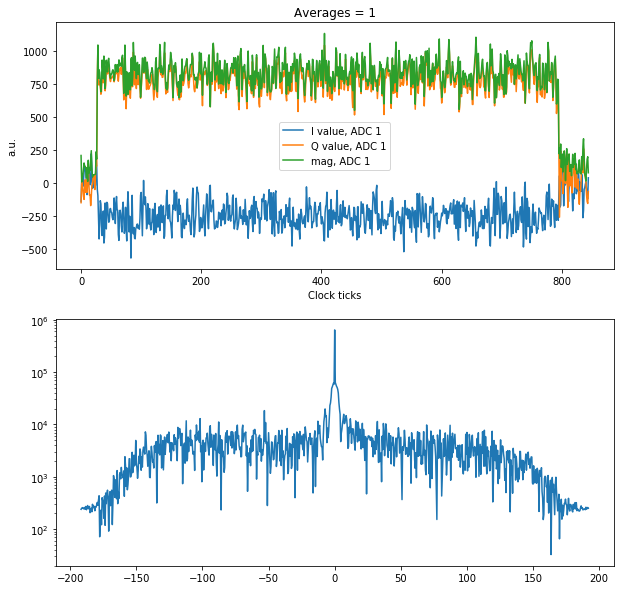

In [6]:
class FSGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        self.declare_gen(ch=cfg["res_ch"], nqz=cfg['nqz'],
                         ro_ch=cfg["ro_ch"])
        self.declare_readout(ch=cfg["ro_ch"], freq=cfg["if_res"],
                             length=soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"]),
                             gen_ch=cfg["res_ch"])

        self.set_pulse_registers(ch=cfg["res_ch"], style="const",
                                 length=soccfg.us2cycles(cfg['length'], gen_ch=cfg['res_ch']),
                                 freq=soccfg.freq2reg(cfg['if_res'],gen_ch=cfg['res_ch'],ro_ch=cfg["ro_ch"]),
                                 gain=cfg['pulse_gain'],
                                 phase=0,
#                                  mode='periodic'
                                 mode='oneshot'
                                 )
        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=soccfg.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

sweepconfig = {
    'adc_trig_offset': 0.35,
    'length': 2,
    'readout_padding': 0.2,
    'relax_delay': 1,
    'reps': 1,
    'soft_avgs': 1
}
config={**hw_cfg,**rfb_cfg,**meas_cfg, **sweepconfig} #combine configs

prog = FSGenLoopbackProgram(soccfg, config)

iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

# Plot results.
iq = iq_list[0]
fig, axs = plt.subplots(2,1,figsize=(10,10))
plot = axs[0]
plot.plot(iq[0], label="I value, ADC %d"%(config['ro_ch']))
plot.plot(iq[1], label="Q value, ADC %d"%(config['ro_ch']))
plot.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_ch']))
plot.set_ylabel("a.u.")
plot.set_xlabel("Clock ticks")
plot.set_title("Averages = " + str(config["soft_avgs"]))
plot.legend()

plot = axs[1]
fft_mag = np.abs(np.fft.fft(iq[0]+1j*iq[1]))
fft_freqs = np.fft.fftfreq(n=iq.shape[-1], d=1/soccfg['readouts'][0]['f_fabric'])
plot.semilogy(np.fft.fftshift(fft_freqs), np.fft.fftshift(fft_mag))
print("peak at %f MHz" % (config['if_res'] - fft_freqs[np.argmax(fft_mag)]))

In [7]:
def noise(di, dq, verbose=True):
    diq = di+1j*dq
    dmean = np.mean(diq)
    dmag = np.abs(dmean)
    if verbose: print("mean signal is %s (magnitude %f)" % (str(dmean), dmag))
    drotated = diq*np.exp(-1j*np.angle(dmean))
    drmsmag = np.std(np.real(drotated)) # noise in the radial direction
    drmsrot = np.std(np.imag(drotated)) # noise in the azimuth direction
    if verbose:
        print("amplitude noise: %f ADU, %f as a fraction of the signal" % (drmsmag, drmsmag/dmag))
        print("phase noise: %f ADU, %f radians" % (drmsrot, drmsrot/dmag))
    return drmsmag, drmsrot

  0%|          | 0/59 [00:00<?, ?it/s]

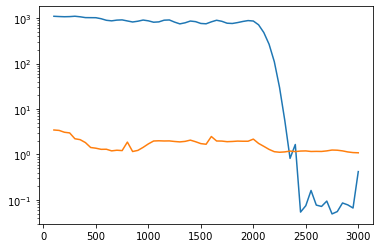

In [8]:
config['length'] = 10
config['reps'] = 10000

freqs = np.arange(100, 3001, 50)

mags = np.zeros((len(freqs),2))
noises = np.zeros((len(freqs),2))

for i, f in tqdm(list(enumerate(freqs))):
    config['if_res'] = f
    
    for j in range(1):
        config['nqz'] = j+1
        prog = FSGenLoopbackProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        res = np.array(res).T[0]
        mags[i,j] = np.abs(res[:,0]+1j*res[:,1])
        rmsmag, rmsrot = noise(prog.di_buf, prog.dq_buf, verbose=False)
        noises[i,j] = rmsmag/soccfg.us2cycles(config['length']+config['readout_padding'], ro_ch=config["ro_ch"])
        
#         (prog.di_buf+1j*prog.dq_buf)
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
plt.semilogy(freqs, mags[:,0], label='gain')
plt.semilogy(freqs, noises[:,0], label='noise')


In [9]:
#scratchwork below